In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.utils.visualisation import *
from src.configs.config import *
from src.configs import config
from src.utils import learner as lrn
from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation
from src.utils import rles
# from src.modules import wider_resnet

%load_ext autoreload
%autoreload 2
# # import losses
# # import metrics


In [5]:
paths = glob('../data/TRAINING/*/*.csv')
paths

['../data/TRAINING/YTS6DUZYSW5KADN1/YTS6DUZYSW5KADN1.csv',
 '../data/TRAINING/E60M2WMELMJVAPBB/E60M2WMELMJVAPBB.csv',
 '../data/TRAINING/E1QZENNLNLCXBKPN/E1QZENNLNLCXBKPN.csv',
 '../data/TRAINING/AZ74029PBGFI0291/AZ74029PBGFI0291.csv',
 '../data/TRAINING/LJJ5AQ6GYW6L2M8D/LJJ5AQ6GYW6L2M8D.csv',
 '../data/TRAINING/SQ77SFLTIREZWKAX/SQ77SFLTIREZWKAX.csv',
 '../data/TRAINING/A14OK5A65AR5AOST/A14OK5A65AR5AOST.csv',
 '../data/TRAINING/T4ZUFU91883CRMQ3/T4ZUFU91883CRMQ3.csv',
 '../data/TRAINING/FOCNEZJJ9UP6IPIC/FOCNEZJJ9UP6IPIC.csv',
 '../data/TRAINING/8B7JP60TYSMLOTJO/8B7JP60TYSMLOTJO.csv']

In [16]:
image = cv2.imread(paths[0].replace('.csv', '_image.png'))

In [ ]:
df = pd.read_csv('_simple_.csv', header=None)
df = df[df[0] == 'ZRYNEEUSVQ213QTY.png']
masks = read_masks(df[1], image.shape[:2])

In [57]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = True
    return img.reshape(shape, order='F')  # Needed to align to RLE direction


def read_masks(mask_rles, shape=(768, 768)):
    masks = np.zeros(shape)
    for idx, rle in enumerate(mask_rles):
        if isinstance(rle, str):
            masks[rle_decode(rle, shape)] = idx + 1
    return masks


In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(131)
a = plt.imshow(image)
plt.subplot(132)
a = plt.imshow(masks)
plt.show()

In [ ]:
dfs = list()

for path in tqdm(paths):
    image = cv2.imread(path.replace('.csv', '_image.png'))
    df = pd.read_csv(path, header=None)
    dfs.append(df)
    masks = rles.read_masks(df[1], image.shape[:2])
    cv2.imwrite(path.replace('.csv', '_instances.png'), masks.astype(np.uint16))


In [ ]:
mask = cv2.imread(path.replace('.csv', '_instances.png'), -1)

plt.figure(figsize=(15, 7))
plt.subplot(121)
a = plt.imshow(image)
plt.colorbar(a)
plt.subplot(122)
a = plt.imshow(mask)
plt.colorbar(a)
plt.show()

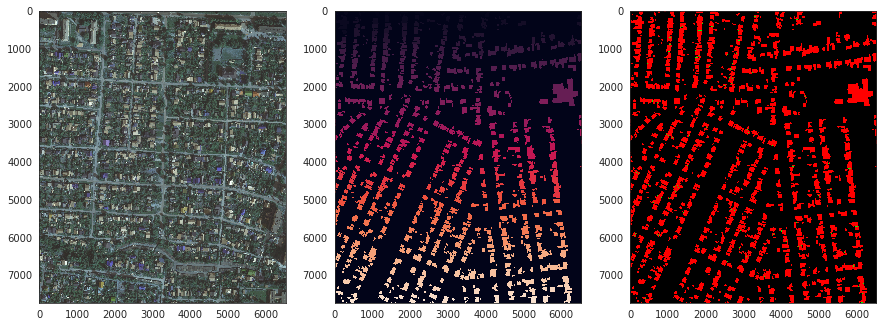

In [34]:
mask = cv2.imread(path.replace('.csv', '_instances.png'), -1)
borders = cv2.imread(path.replace('.csv', '_MB.png'))

plt.figure(figsize=(15, 7))
plt.subplot(131)
a = plt.imshow(image)
plt.subplot(132)
a = plt.imshow(mask)
plt.subplot(133)
a = plt.imshow(borders)
plt.show()

### mv name.png -> name_image.png

In [106]:
import shutil

template = '../data/TRAINING/*'
paths = glob(template)
for path in paths:
    path = os.path.join(path, '.'.join([os.path.basename(path), 'png']))
    shutil.move(path, path.replace('.png', '_image.png'))

template = '../data/TESTING/*'
paths = glob(template)
for path in paths:
    path = os.path.join(path, '.'.join([os.path.basename(path), 'png']))
    shutil.move(path, path.replace('.png', '_image.png'))

# Crop patches

In [6]:
side = 1024
reshape = 512
step = 512
template = '../data/TRAINING/*/*{}'

In [9]:
postfix = '_image.png'
paths = glob(template.format(postfix))

for path in tqdm(paths):
    image = cv2.imread(path)[..., ::-1]
    shape = np.array(image.shape[:2])
    nb_crops = np.ceil((shape - side) / step).astype(np.int)
    xs = np.linspace(0, shape[0] - side, num=nb_crops[0]).astype(np.int)
    ys = np.linspace(0, shape[1] - side, num=nb_crops[1]).astype(np.int)
    for i, xi in enumerate(xs[:-1]):
        for j, yi in enumerate(ys[:-1]):
            img = image[xi: xi + side, yi: yi + side]
            img_ = cv2.resize(img, (reshape, reshape))
            cv2.imwrite(path.replace(postfix, '_{}_{}_{}{}'.format(i, j, 'shrinked', postfix)), img_)
            cv2.imwrite(path.replace(postfix, '_{}_{}_{}{}'.format(i, j, 'orig', postfix)), img)

100%|██████████| 10/10 [02:05<00:00, 12.58s/it]


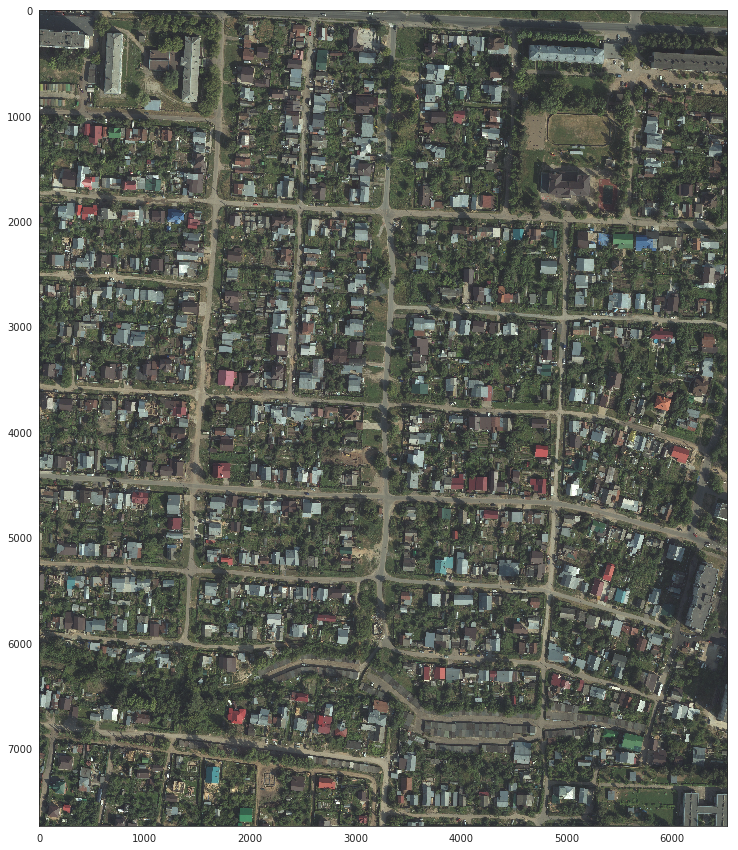

In [10]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

In [11]:
postfix = '_borders.png'
paths = glob(template.format(postfix))

for path in tqdm(paths):
    image = cv2.imread(path)
    shape = np.array(image.shape[:2])
    nb_crops = np.ceil((shape - side) / step).astype(np.int)
    xs = np.linspace(0, shape[0] - side, num=nb_crops[0]).astype(np.int)
    ys = np.linspace(0, shape[1] - side, num=nb_crops[1]).astype(np.int)
    for i, xi in enumerate(xs[:-1]):
        for j, yi in enumerate(ys[:-1]):
            img = image[xi: xi + side, yi: yi + side]
            img[..., 0] &= np.logical_not(img[..., 1])
            img[..., 0] *= 255
            cv2.imwrite(path.replace(postfix, '_{}_{}_{}{}'.format(i, j, 'orig', postfix)), img)            

            img_ = cv2.resize(img, (reshape, reshape))
            img_[..., 0] &= np.logical_not(img_[..., 1])
            img_[..., 0] *= 255
            cv2.imwrite(path.replace(postfix, '_{}_{}_{}{}'.format(i, j, 'shrinked', postfix)), img_)


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


In [112]:
postfix = '_MB.png'
paths = glob(template.format(postfix))

for path in tqdm(paths):
    image = cv2.imread(path)

    buildings = image[..., 0] > 0
    borders = image[..., 1] > 0

    buildings_ = scipy.ndimage.binary_dilation(buildings, iterations=10)
    borders_ = scipy.ndimage.binary_dilation(borders, iterations=5)
    borders = ((borders  | buildings_) * borders_) & np.logical_not(buildings)
    image[..., 1] = borders * 255
    cv2.imwrite(path.replace('_MB', '_borders'), image)

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


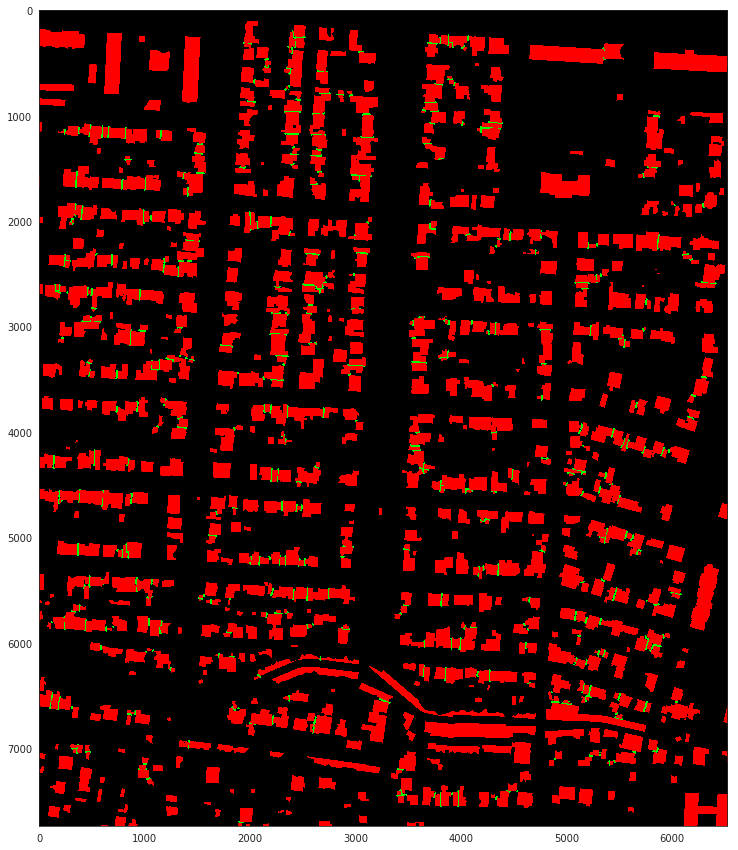

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

## test processing

In [16]:
side = 672
step = side // 2
template = '../data/TESTING/*/*{}'

In [27]:
postfix = '_image.png'
paths = glob(template.format(postfix))

for path in tqdm(paths):
    image = cv2.imread(path)[..., ::-1]
    shape = np.array(image.shape[:2])[::-1] // 2
    image = cv2.resize(image, tuple(shape.tolist()))
    shape = np.array(image.shape[:2])
    nb_crops = np.ceil((shape - side) / step).astype(np.int)
    xs = np.linspace(0, shape[0] - side, num=nb_crops[0]).astype(np.int)
    ys = np.linspace(0, shape[1] - side, num=nb_crops[1]).astype(np.int)
    for i, xi in enumerate(xs[:-1]):
        for j, yi in enumerate(ys[:-1]):
            img = image[xi: xi + side, yi: yi + side]
            cv2.imwrite(path.replace(postfix, '_{}_{}{}'.format(i, j, postfix)), img)

100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


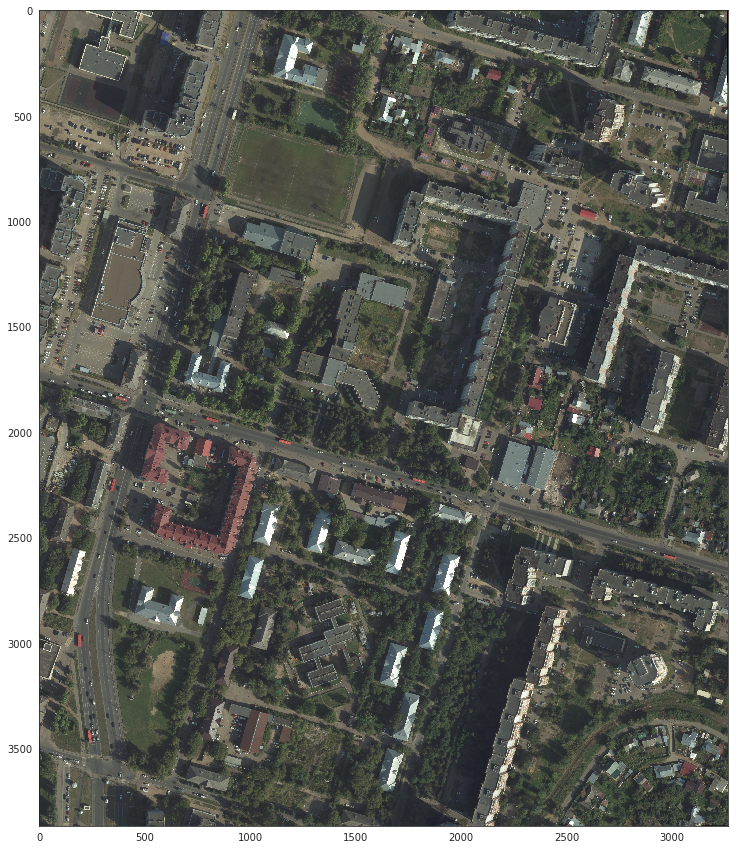

In [29]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

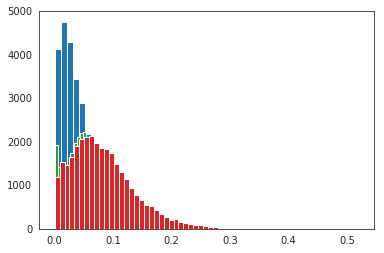

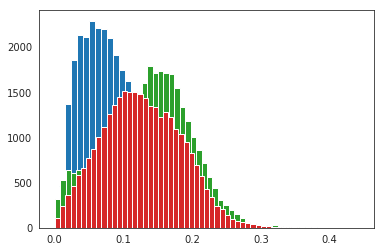

In [26]:
for i in range(4):
    means = np.array(means);
    plt.hist(means[:, i], 50);
plt.show()
for i in range(4):
    stds = np.array(stds);
    plt.hist(stds[:, i], 50);